<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_Test_Differences_Price_LSTM_CNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=c900333883e05f461d00c6b50edd575877fd7c7adedda92ec11ddfff779e51c3
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [17]:
import yfinance as yf
daily_data = yf.download(tickers='AAPL', period = '1000wk', interval = '1d')
daily_data['Yesterday'] = daily_data['Close'].shift(periods=1, fill_value=0)
daily_data['Difference'] = daily_data['Close'] - daily_data['Yesterday']
daily_data['%Difference'] = (daily_data['Difference'] / daily_data['Close']) * 100
daily_data = daily_data[1:]
daily_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Yesterday,Difference,%Difference
Date,,,,,,,,,
2002-08-29,0.261607,0.269286,0.259107,0.262500,0.225387,164169600,0.262500,0.000000,0.000000
2002-08-30,0.263036,0.270357,0.260357,0.263393,0.226154,193519200,0.262500,0.000893,0.339047
2002-09-03,0.258750,0.259821,0.250893,0.250893,0.215421,276936800,0.263393,-0.012500,-4.982211
2002-09-04,0.253571,0.263929,0.253036,0.258571,0.222013,420660800,0.250893,0.007678,2.969398
2002-09-05,0.253929,0.256429,0.250893,0.253214,0.217414,226178400,0.258571,-0.005357,-2.115601
...,...,...,...,...,...,...,...,...,...
2021-10-21,148.809998,149.639999,147.869995,149.479996,149.479996,61421000,149.259995,0.220001,0.147178
2021-10-22,149.690002,150.179993,148.639999,148.690002,148.690002,58839600,149.479996,-0.789993,-0.531302
2021-10-25,148.679993,149.369995,147.619995,148.639999,148.639999,50720600,148.690002,-0.050003,-0.033640


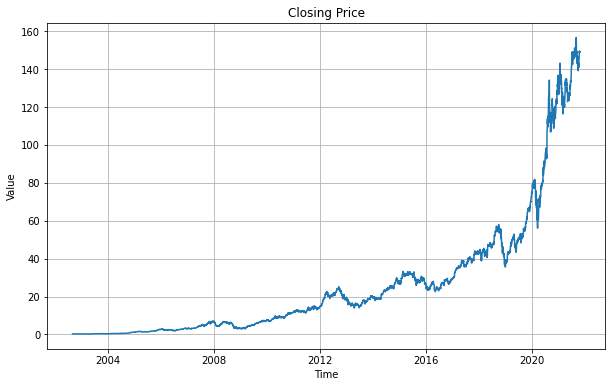

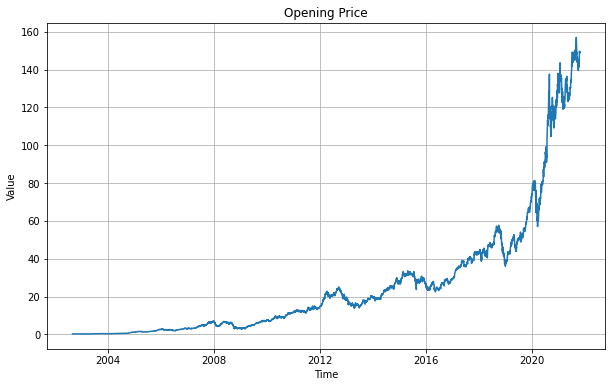

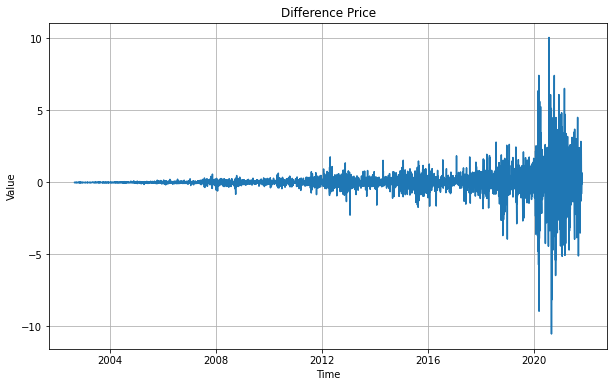

In [18]:
#from sklearn.preprocessing import StandardScaler

#series = one_d_data['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(daily_data.Close)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.title("Closing Price")
plt.show()

series = np.array(daily_data.Open)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plt.title("Opening Price")
plot_series(time, series)
plt.show()

series = np.array(daily_data.Difference)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plt.title("Difference Price")
plot_series(time, series)

In [19]:
split_time = 4500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4500,)
Epoch 1/100
18/18 [==============================] - 35s 56ms/step - loss: 0.5137 - mae: 0.7674
Epoch 2/100
18/18 [==============================] - 1s 56ms/step - loss: 0.4972 - mae: 0.7499
Epoch 3/100
18/18 [==============================] - 1s 57ms/step - loss: 0.4878 - mae: 0.7515
Epoch 4/100
18/18 [==============================] - 1s 56ms/step - loss: 0.4841 - mae: 0.7581
Epoch 5/100
18/18 [==============================] - 1s 60ms/step - loss: 0.4817 - mae: 0.7608
Epoch 6/100
18/18 [==============================] - 1s 57ms/step - loss: 0.4791 - mae: 0.7595
Epoch 7/100
18/18 [==============================] - 1s 58ms/step - loss: 0.4761 - mae: 0.7561
Epoch 8/100
18/18 [==============================] - 1s 56ms/step - loss: 0.4730 - mae: 0.7519
Epoch 9/100
18/18 [==============================] - 1s 62ms/step - loss: 0.4695 - mae: 0.7465
Epoch 10/100
18/18 [======================

(1e-08, 0.0001, 0.0, 25.0)

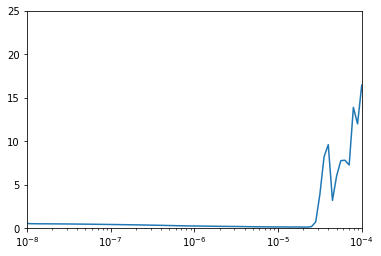

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 25])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
45/45 [==============================] - 5s 35ms/step - loss: 0.1444 - mae: 0.3851
Epoch 2/150
45/45 [==============================] - 2s 37ms/step - loss: 0.0977 - mae: 0.2780
Epoch 3/150
45/45 [==============================] - 2s 35ms/step - loss: 0.1058 - mae: 0.3151
Epoch 4/150
45/45 [==============================] - 2s 36ms/step - loss: 0.0964 - mae: 0.2784
Epoch 5/150
45/45 [==============================] - 2s 35ms/step - loss: 0.0987 - mae: 0.2895
Epoch 6/150
45/45 [==============================] - 2s 38ms/step - loss: 0.0955 - mae: 0.2738
Epoch 7/150
45/45 [==============================] - 2s 35ms/step - loss: 0.1028 - mae: 0.3056
Epoch 8/150
45/45 [==============================] - 2s 35ms/step - loss: 0.0937 - mae: 0.2645
Epoch 9/150
45/45 [==============================] - 2s 36ms/step - loss: 0.0961 - mae: 0.2782
Epoch 10/150
45/45 [==============================] - 2s 37ms/step - loss: 0.0945 - mae: 0.2700
Epoch 11/150
45/45 [=============================

In [27]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

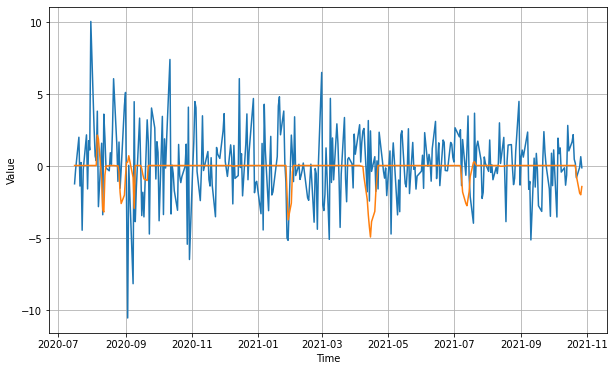

In [28]:
#Differences
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

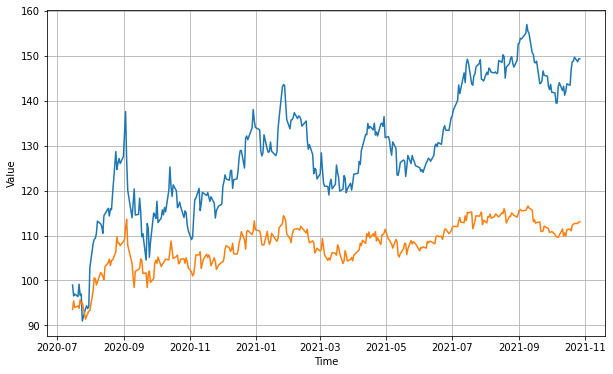

In [19]:
#Opening
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

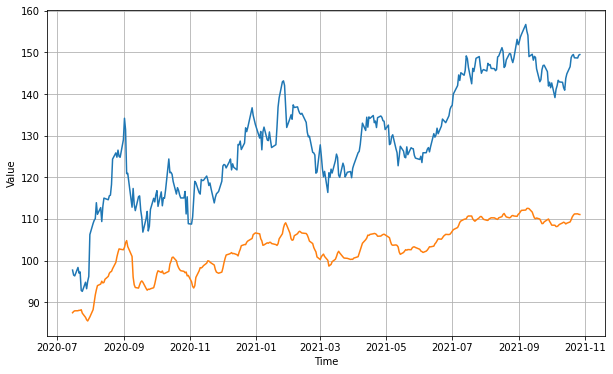

In [47]:
#Closing
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS